# Predicting House Prices

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import warnings
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

#

In [67]:
## Step 1: Data Loading

print("DATA LOADING AND EXPLORATION ")
print("=" * 80)
try:
    df = pd.read_csv('/content/drive/MyDrive/CoadingNinja/HousePriceIndia.csv')
except FileNotFoundError:
    print("Error: 'HousePriceIndia.csv' not found. Please ensure the file is in the directory.")
    exit()

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:\n{df.head()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nBasic Statistics:\n{df.describe()}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

# Feature Engineering
df['house_age'] = 2025 - df['Built Year']
df['is_renovated'] = (df['Renovation Year'] > 0).astype(int)
df['total_area'] = df['living area'] + df['Area of the basement']

DATA LOADING AND EXPLORATION 
Dataset Shape: (14620, 23)

First 5 rows:
           id   Date  number of bedrooms  number of bathrooms  living area  \
0  6762810145  42491                   5                 2.50         3650   
1  6762810635  42491                   4                 2.50         2920   
2  6762810998  42491                   5                 2.75         2910   
3  6762812605  42491                   4                 2.50         3310   
4  6762812919  42491                   3                 2.00         2710   

   lot area  number of floors  waterfront present  number of views  \
0      9050               2.0                   0                4   
1      4000               1.5                   0                0   
2      9480               1.5                   0                0   
3     42998               2.0                   0                0   
4      4500               1.5                   0                0   

   condition of the house  ...  Built 

In [68]:
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Target variable distribution
print(f"\nTarget Variable Statistics:")
print(f"Mean Price: ${df['Price'].mean():,.2f}")
print(f"Median Price: ${df['Price'].median():,.2f}")
print(f"Std Dev: ${df['Price'].std():,.2f}")
print(f"Min Price: ${df['Price'].min():,.2f}")
print(f"Max Price: ${df['Price'].max():,.2f}")

# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)
print(f"\nTop 10 Features Correlated with Price:")
print(price_correlation.head(11))


EXPLORATORY DATA ANALYSIS

Target Variable Statistics:
Mean Price: $538,932.22
Median Price: $450,000.00
Std Dev: $367,532.38
Min Price: $78,000.00
Max Price: $7,700,000.00

Top 10 Features Correlated with Price:
Price                                    1.000000
living area                              0.712169
total_area                               0.676559
grade of the house                       0.671814
Area of the house(excluding basement)    0.615220
living_area_renov                        0.584924
number of bathrooms                      0.531735
number of views                          0.395973
Area of the basement                     0.330202
number of bedrooms                       0.308460
Lattitude                                0.297490
Name: Price, dtype: float64


In [69]:
print(" Data Preprocessing & Scaling")
print("=" * 80)
feature_columns = [
    'number of bedrooms', 'number of bathrooms', 'living area', 'lot area',
    'number of floors', 'waterfront present', 'number of views',
    'condition of the house', 'grade of the house',
    'Area of the house(excluding basement)', 'Area of the basement',
    'house_age', 'is_renovated', 'total_area',
    'Number of schools nearby', 'Distance from the airport'
]

X = df[feature_columns].fillna(df[feature_columns].median()) # Imputation
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model constants
n_test = y_test.shape[0]
p_full = X_test.shape[1] # number of features
results = []

 Data Preprocessing & Scaling


In [70]:
print("Helper Functions for Evaluation")
print("=" * 80)
def adjusted_r2(y_true, y_pred, n, p):
    """Calculates the Adjusted R-squared metric."""
    r2 = r2_score(y_true, y_pred)
    if p < 1: return r2 # Return R2 if p=0 (for baselines)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def mape(y_true, y_pred):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(name, y_true, y_pred, n, p):
    """Calculates all metrics and plots residuals."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(y_true, y_pred, n, p)
    mape_val = mape(y_true, y_pred)
    residuals = y_true - y_pred

    print(f"\n--- {name} Evaluation ---")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAE: {mae:,.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Adjusted R²: {adj_r2:.4f}")
    print(f"  MAPE: {mape_val:.2f}%")
    print(f"  Residual Mean: {residuals.mean():,.2f}")

    # Plot residual distribution (Diagnostic Step)
    plt.figure()
    sns.histplot(residuals, bins=50, kde=True)
    plt.title(f'Residual Distribution - {name} Model')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    return {
        'name': name, 'rmse': rmse, 'mae': mae, 'r2': r2,
        'adj_r2': adj_r2, 'mape': mape_val
    }

Helper Functions for Evaluation


 BASELINE MODELS

--- Mean Baseline Evaluation ---
  RMSE: 375,435.65
  MAE: 237,863.70
  R²: -0.0002
  Adjusted R²: -0.0002
  MAPE: 53.29%
  Residual Mean: 5,742.51


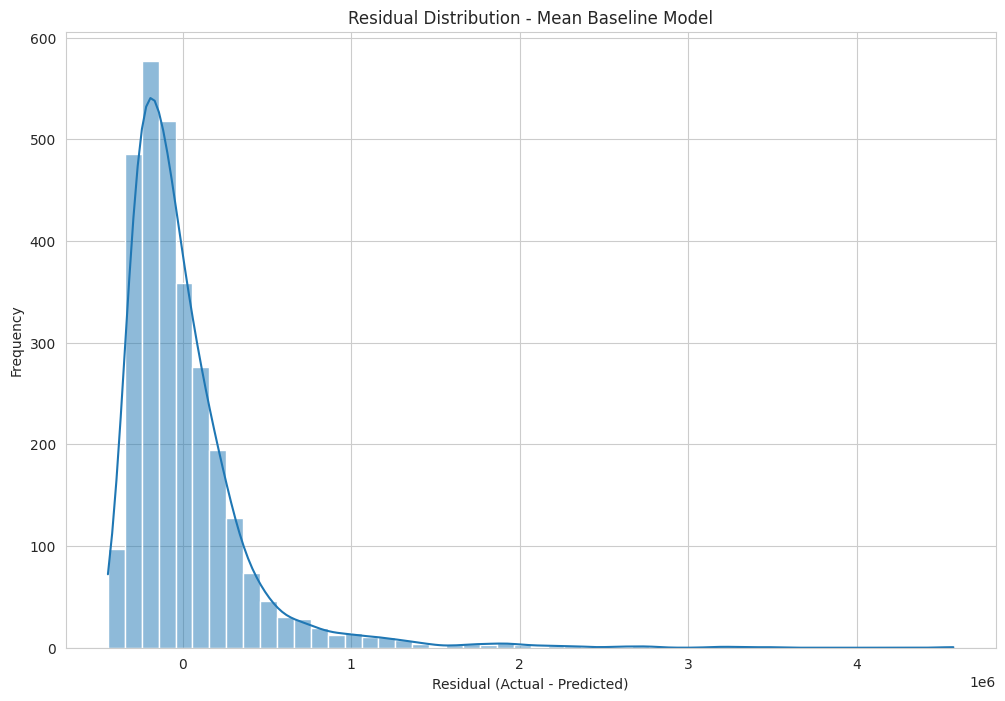


--- Median Baseline Evaluation ---
  RMSE: 386,867.04
  MAE: 226,052.41
  R²: -0.0621
  Adjusted R²: -0.0621
  MAPE: 42.52%
  Residual Mean: 93,526.23


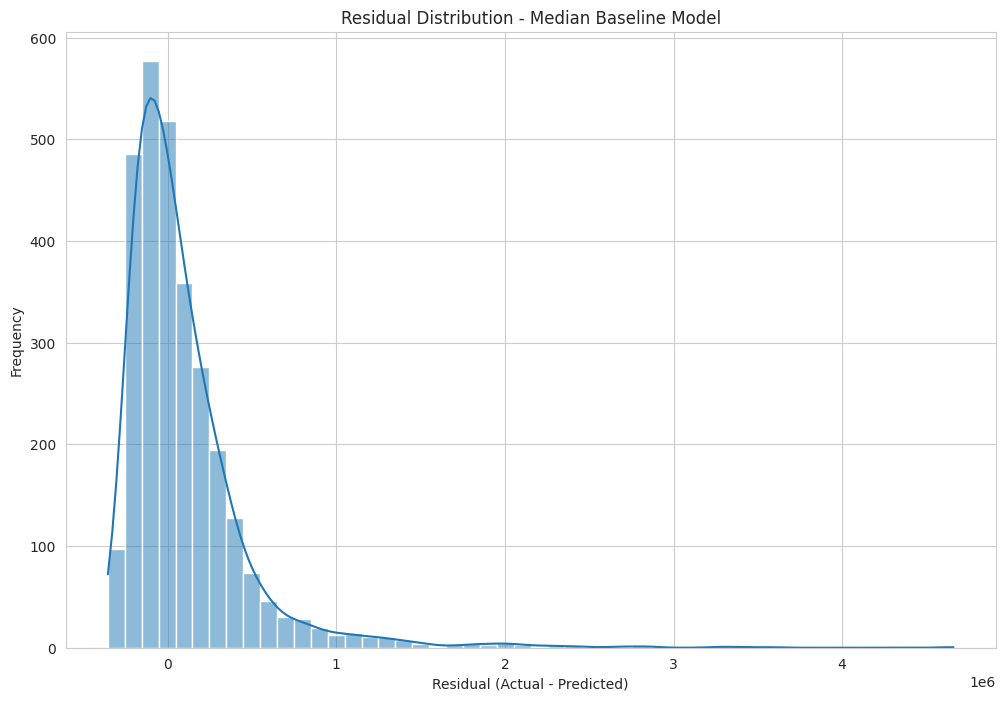

In [71]:
print(" BASELINE MODELS")
print("="*80)
mean_pred = np.full(len(y_test), y_train.mean())
median_pred = np.full(len(y_test), y_train.median())

results.append(evaluate_model("Mean Baseline", y_test, mean_pred, n_test, 0)) # p=0 for baselines
results.append(evaluate_model("Median Baseline", y_test, median_pred, n_test, 0)) # p=0 for baselines

 SIMPLE LINEAR REGRESSION (SLR)

--- Simple Linear Regression Evaluation ---
  RMSE: 259,221.01
  MAE: 172,726.52
  R²: 0.5232
  Adjusted R²: 0.5230
  MAPE: 35.40%
  Residual Mean: -114.97


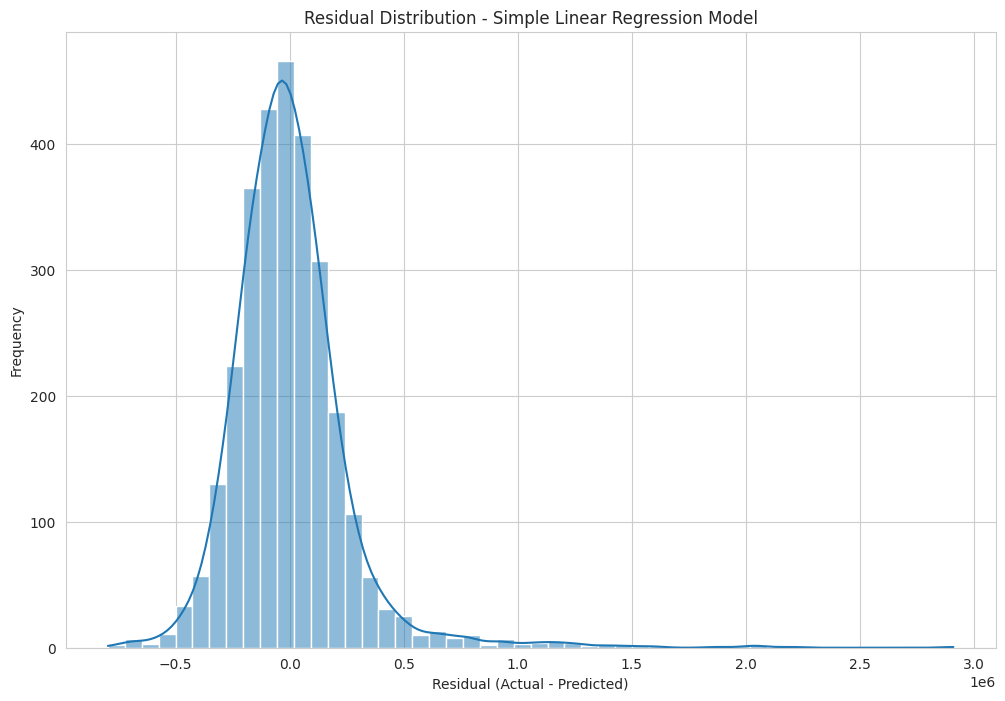

In [72]:

print(" SIMPLE LINEAR REGRESSION (SLR)")
print("="*80)
slr = LinearRegression()
# Use 'living area' as the strongest predictor based on typical correlations
slr.fit(X_train[['living area']], y_train)
slr_pred = slr.predict(X_test[['living area']])
results.append(evaluate_model("Simple Linear Regression", y_test, slr_pred, n_test, 1))

 MULTIPLE LINEAR REGRESSION (MLR)

--- Multiple Linear Regression Evaluation ---
  RMSE: 212,778.42
  MAE: 138,268.83
  R²: 0.6787
  Adjusted R²: 0.6770
  MAPE: 28.56%
  Residual Mean: 3,945.74


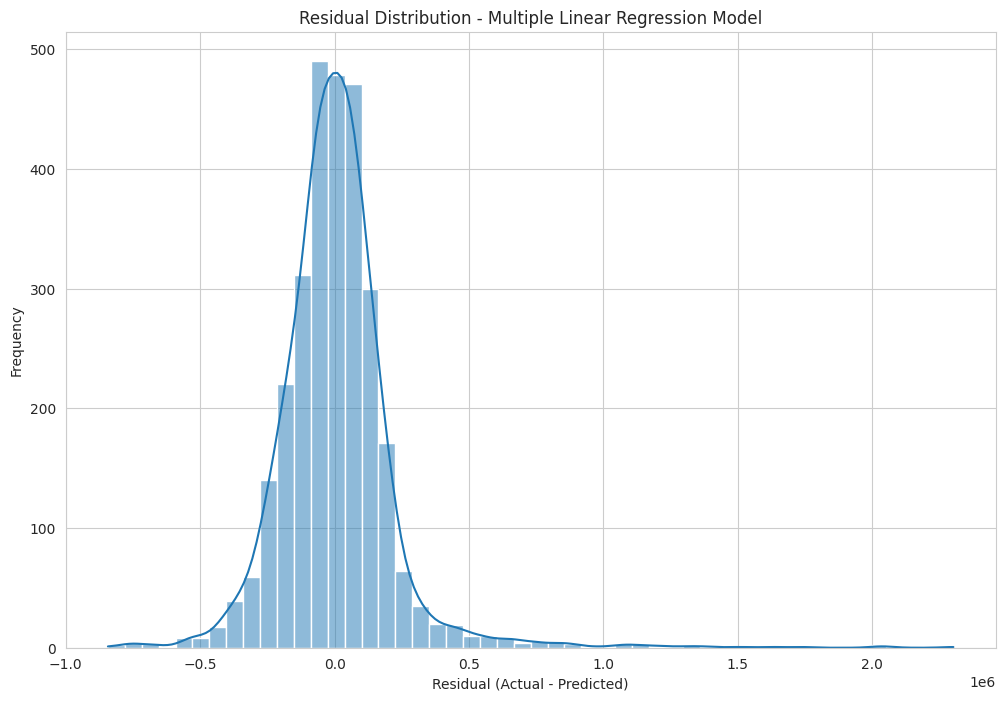

In [73]:
print(" MULTIPLE LINEAR REGRESSION (MLR)")
print("="*80)
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
mlr_pred = mlr.predict(X_test_scaled)
results.append(evaluate_model("Multiple Linear Regression", y_test, mlr_pred, n_test, p_full))

In [74]:
print(" MULTICOLLINEARITY ANALYSIS (VIF)")
print("="*80)

# Calculate VIF for each feature in the scaled training set
vif_data = pd.DataFrame()
vif_data["Feature"] = feature_columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i)
                   for i in range(len(feature_columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)
print("\nVariance Inflation Factors (VIF) on Training Data:")
print(vif_data.to_string(index=False))
print(f"\nJustification: High VIF values (>10) indicate multicollinearity, which justifies the use of regularization models.")

 MULTICOLLINEARITY ANALYSIS (VIF)

Variance Inflation Factors (VIF) on Training Data:
                              Feature      VIF
                          living area      inf
                           total_area      inf
                 Area of the basement      inf
Area of the house(excluding basement)      inf
                  number of bathrooms 3.343568
                   grade of the house 2.991009
                            house_age 2.024754
                     number of floors 1.874030
                   number of bedrooms 1.687781
                      number of views 1.385812
               condition of the house 1.252725
                   waterfront present 1.203756
                         is_renovated 1.154817
                             lot area 1.064330
            Distance from the airport 1.000967
             Number of schools nearby 1.000379

Justification: High VIF values (>10) indicate multicollinearity, which justifies the use of regularization models.

 REGULARIZATION MODELS

--- Ridge Regression Evaluation ---
  RMSE: 212,733.40
  MAE: 138,058.81
  R²: 0.6789
  Adjusted R²: 0.6771
  MAPE: 28.50%
  Residual Mean: 3,896.50


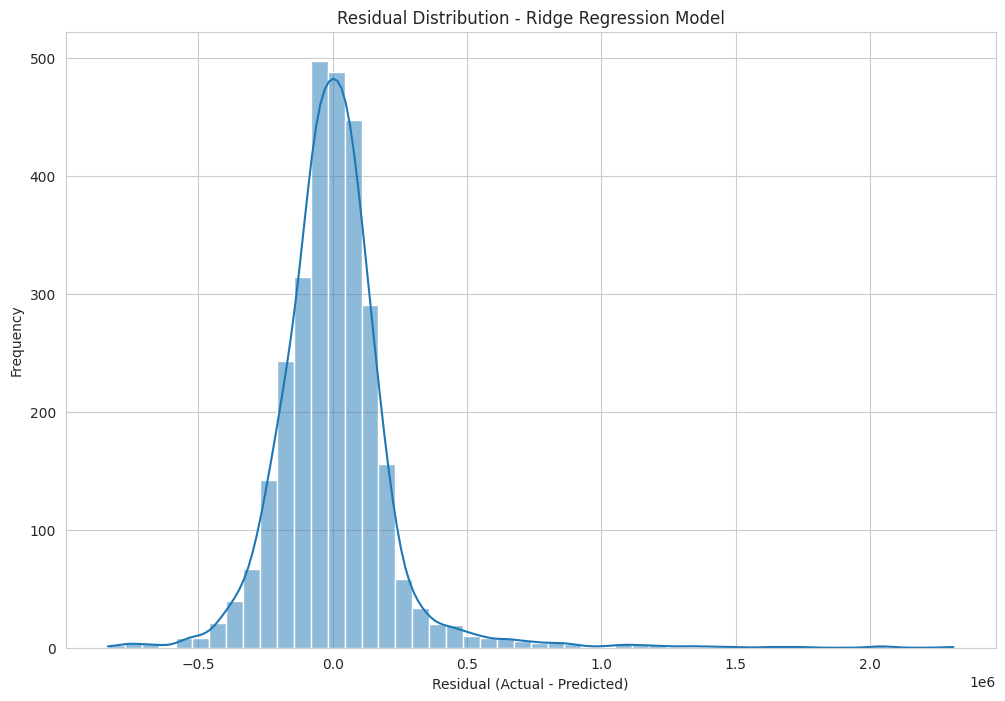


--- Lasso Regression Evaluation ---
  RMSE: 212,586.74
  MAE: 137,889.13
  R²: 0.6793
  Adjusted R²: 0.6775
  MAPE: 28.47%
  Residual Mean: 3,811.66


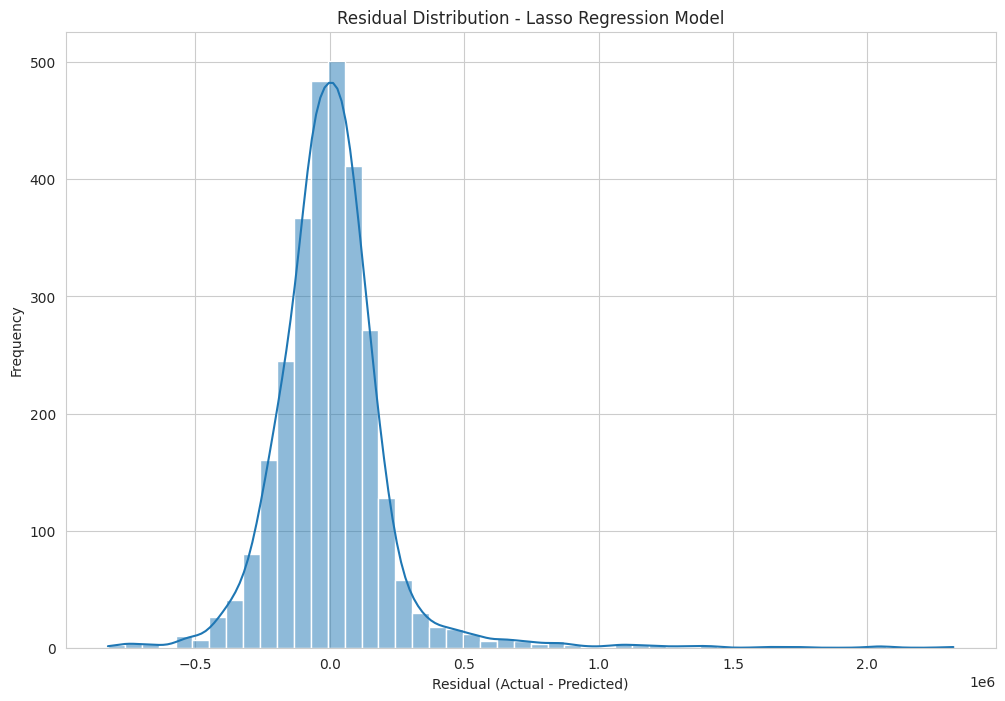


--- ElasticNet Regression Evaluation ---
  RMSE: 371,544.37
  MAE: 234,959.91
  R²: 0.0204
  Adjusted R²: 0.0150
  MAPE: 52.60%
  Residual Mean: 5,636.78


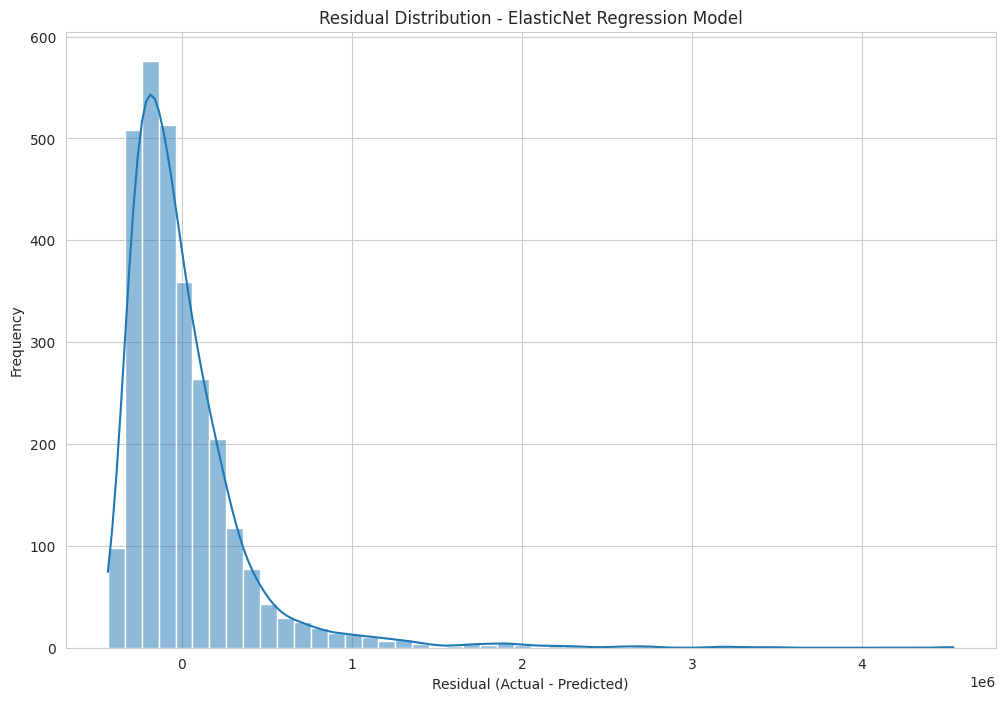

In [75]:
print(" REGULARIZATION MODELS")
print("="*80)

# Ridge Regression (L2 penalty)
ridge = Ridge(alpha=100, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
results.append(evaluate_model("Ridge Regression", y_test, ridge_pred, n_test, p_full))

# Lasso Regression (L1 penalty - feature selection)
lasso = Lasso(alpha=1000, random_state=42, max_iter=10000) # Increased alpha for effect
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
results.append(evaluate_model("Lasso Regression", y_test, lasso_pred, n_test, p_full))

# ElasticNet Regression (L1 + L2 penalty)
elastic = ElasticNet(alpha=500, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic.fit(X_train_scaled, y_train)
elastic_pred = elastic.predict(X_test_scaled)
results.append(evaluate_model("ElasticNet Regression", y_test, elastic_pred, n_test, p_full))

In [76]:
print("STEP 8: CROSS-VALIDATION (5-Fold RMSE)")
print("="*80)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mlr_cv_scores = cross_val_score(mlr, X_train_scaled, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
print(f"MLR CV RMSE: ${-mlr_cv_scores.mean():,.2f} (+/- ${mlr_cv_scores.std():,.2f})")
print(f"Ridge CV RMSE: ${-ridge_cv_scores.mean():,.2f} (+/- ${ridge_cv_scores.std():,.2f})")

STEP 8: CROSS-VALIDATION (5-Fold RMSE)
MLR CV RMSE: $213,922.85 (+/- $11,362.65)
Ridge CV RMSE: $213,925.89 (+/- $11,367.28)


In [77]:
print("STEP 9: MODEL COMPARISON LEADERBOARD")
print("="*80)
df_results = pd.DataFrame(results)
# Rank by lowest RMSE and highest Adjusted R^2
leaderboard = df_results.sort_values(['rmse', 'adj_r2'], ascending=[True, False]).reset_index(drop=True)
leaderboard['Rank'] = leaderboard.index + 1
print(leaderboard.to_string(index=False))

champion = leaderboard.iloc[0]
print(f"\nCHAMPION MODEL SELECTED: **{champion['name']}**")
print(f"Rationale: Selected based on the lowest Test RMSE and highest Adjusted R².")

# Map model name to object for saving
model_map = {
    'Simple Linear Regression': slr, 'Multiple Linear Regression': mlr,
    'Ridge Regression': ridge, 'Lasso Regression': lasso,
    'ElasticNet Regression': elastic
}
champion_model = model_map.get(champion['name'], None)

STEP 9: MODEL COMPARISON LEADERBOARD
                      name          rmse           mae        r2    adj_r2      mape  Rank
          Lasso Regression 212586.735346 137889.126412  0.679297  0.677532 28.473613     1
          Ridge Regression 212733.402565 138058.812813  0.678854  0.677087 28.495509     2
Multiple Linear Regression 212778.420697 138268.829851  0.678718  0.676950 28.560691     3
  Simple Linear Regression 259221.007184 172726.518230  0.523162  0.522999 35.399442     4
     ElasticNet Regression 371544.367802 234959.913200  0.020393  0.015001 52.596803     5
             Mean Baseline 375435.649277 237863.704801 -0.000234 -0.000234 53.286806     6
           Median Baseline 386867.038260 226052.410739 -0.062072 -0.062072 42.516165     7

CHAMPION MODEL SELECTED: **Lasso Regression**
Rationale: Selected based on the lowest Test RMSE and highest Adjusted R².


In [78]:
print("STEP 13: SAVING MODEL ARTIFACTS")
print("=" * 80)

if champion_model is not None:
    # Define the base path for saving to Google Drive
    gdrive_save_path = '/content/drive/MyDrive/CoadingNinja/'

    # 1. Save Model and Scaler
    joblib.dump(champion_model, gdrive_save_path + 'champion_model.joblib')
    joblib.dump(scaler, gdrive_save_path + 'scaler.joblib')
    print(f"\u2713 Saved: champion_model.joblib- Trained {champion['name']} model")
    print("\u2713 Saved: scaler.joblib - Feature scaler")

    # 2. Save Predictions CSV
    # 'preds' variable is already calculated for the champion model predictions
    preds = champion_model.predict(X_test_scaled)
    residuals = y_test - preds
    predictions_df = pd.DataFrame({
        'Actual_Price': y_test.values,
        'Predicted_Price': preds,
        'Residual': residuals.values
    })
    predictions_df.to_csv(gdrive_save_path + 'houseprice_predictions_test.csv', index=False)
    print("\u2713 Saved: houseprice_predictions_test.csv - Test predictions")

    # 3. Save Metrics JSON
    model_metrics = {
        'model_name': champion['name'],
        'test_rmse': float(champion['rmse']),
        'test_mae': float(champion['mae']),
        'test_r2': float(champion['r2']),
        'test_mape': float(champion['mape']),
        'features_used': feature_columns,
        'training_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0])
    }

    with open(gdrive_save_path + 'test_metrics.json', 'w') as f:
        json.dump(model_metrics, f, indent=4)
    print("\u2713 Saved: test_metrics.json - Model performance metrics")

    # 4. Save Leaderboard CSV
    leaderboard.to_csv(gdrive_save_path + 'model_leaderboard.csv', index=False)
    print("\u2713 Saved: model_leaderboard.csv - All models comparison")

    print("\n" + "=" * 80)
    print("PROJECT COMPLETED SUCCESSFULLY!")
    print("=" * 80)

else:
    print("\nChampion model is a baseline, no model artifacts saved.")


STEP 13: SAVING MODEL ARTIFACTS
✓ Saved: champion_model.joblib- Trained Lasso Regression model
✓ Saved: scaler.joblib - Feature scaler
✓ Saved: houseprice_predictions_test.csv - Test predictions
✓ Saved: test_metrics.json - Model performance metrics
✓ Saved: model_leaderboard.csv - All models comparison

PROJECT COMPLETED SUCCESSFULLY!
